In [1]:
import zipfile
from six.moves import urllib
import re
import os
from sys import path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics as sk_metrics
from sklearn import model_selection as sk_model_selection
from tensorflow.keras import models as tf_models
import seaborn as sns
import math

In [2]:
CarTruckPath = os.path.join("Car_Or_Truck_Data") #making a path for the data
CarTruckURL = 'https://github.com/yitz25/Car-or-Truck-CV/raw/main/car_or_truck.zip' #url for the data
def FetchData(car_truck_url=CarTruckURL, car_truck_path=CarTruckPath):  #function to fetch and extract data from the url
     if not os.path.isdir(car_truck_path):
         os.makedirs(car_truck_path)
     zip_path = os.path.join(car_truck_path, "lego.zip")
     urllib.request.urlretrieve(car_truck_url, zip_path)
     with zipfile.ZipFile(zip_path, 'r') as gw_zip:
         gw_zip.extractall(path=car_truck_path)

FetchData()

In [3]:
#seeting seed to ensure reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [4]:
#Paths for the different datasets
path_train = '/content/Car_Or_Truck_Data/train'
path_valid = '/content/Car_Or_Truck_Data/valid'
path_test = '/content/Car_Or_Truck_Data/test'

# Load training, validation, and test sets
ds_train_ = image_dataset_from_directory(
    path_train,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    path_valid,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)
ds_test_ = image_dataset_from_directory(
    path_test,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


In [5]:
#Computer Vision Model
model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),

    # Base block 1
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Base block 2
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Base block 3
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Base block 4
    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=1, activation='sigmoid')
])

In [6]:
#Callback to save the best model for later use
callback_save = keras.callbacks.ModelCheckpoint(
    "best.hdf5",
    monitor='val_loss',
    save_best_only=True,
)

In [7]:
#Compiling of the model
model.compile(
    optimizer= keras.optimizers.Adam(epsilon = 0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
#Training the model
history = model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_valid,
    callbacks=[callback_save]
)

Epoch 1/25
80/80 [==============================] - 13s 90ms/step - loss: 0.6835 - accuracy: 0.5787 - val_loss: 0.6812 - val_accuracy: 0.5785
Epoch 2/25
 1/80 [..............................] - ETA: 3s - loss: 0.6911 - accuracy: 0.5469

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 4s 52ms/step - loss: 0.6787 - accuracy: 0.5787 - val_loss: 0.6678 - val_accuracy: 0.5785
Epoch 3/25
80/80 [==============================] - 4s 51ms/step - loss: 0.6696 - accuracy: 0.5841 - val_loss: 0.6629 - val_accuracy: 0.5795
Epoch 4/25
80/80 [==============================] - 4s 50ms/step - loss: 0.6671 - accuracy: 0.5867 - val_loss: 0.6605 - val_accuracy: 0.5935
Epoch 5/25
80/80 [==============================] - 4s 49ms/step - loss: 0.6633 - accuracy: 0.5929 - val_loss: 0.6613 - val_accuracy: 0.5939
Epoch 6/25
80/80 [==============================] - 4s 49ms/step - loss: 0.6513 - accuracy: 0.6174 - val_loss: 0.6501 - val_accuracy: 0.6070
Epoch 7/25
80/80 [==============================] - 4s 49ms/step - loss: 0.6268 - accuracy: 0.6426 - val_loss: 0.6053 - val_accuracy: 0.6700
Epoch 8/25
80/80 [==============================] - 4s 54ms/step - loss: 0.5957 - accuracy: 0.6850 - val_loss: 0.6023 - val_accuracy: 0.6714
Epoch 9/25
80/80 [======

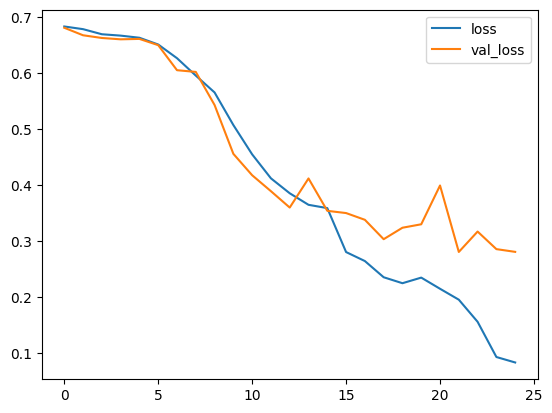

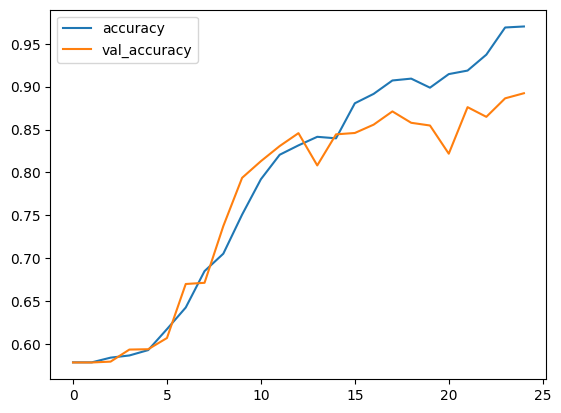

In [9]:
#Making the dataframe for the history of the model
history_frame = pd.DataFrame(history.history)
#Plots to compare de loss and accuracy of the training and validation sets
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [10]:
#Loading the best model
model = tf_models.load_model("best.hdf5")

In [11]:
#Making the predictions with the model for the test set and saving the true labels
y_pred_prob = []
y_test = []
for _X_test, _y_test in ds_test:
    y_pred_prob.extend(model.predict(_X_test))
    y_test.extend(_y_test)

# Making the probs of prediction to labels using a theshold of 0.5
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]

# Metrics
print(f"Accuracy score on test data: {sk_metrics.accuracy_score(y_test, y_pred)}")
print(f"Macro F1 score on test data: {sk_metrics.f1_score(y_test, y_pred, average='macro')}")

2/2 [==============================] - 0s 34ms/step
Accuracy score on test data: 0.85
Macro F1 score on test data: 0.849624060150376


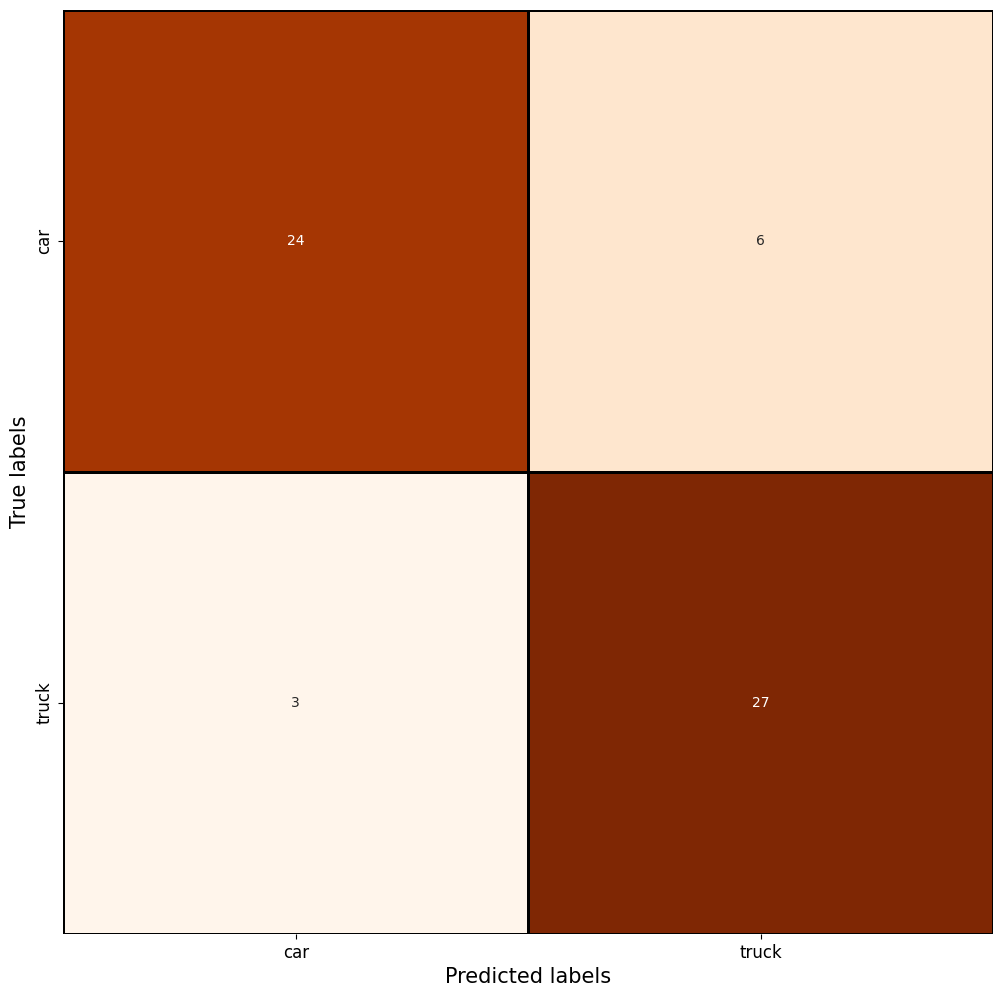

In [12]:
# Labels of the classes
labels = ['car','truck']

# Calculate confusion matrix
confusion_matrix = sk_metrics.confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

# Show confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=12);

In [13]:
# Lists to save the info of the errors
error_images = []
error_label = []
error_pred = []
error_prob = []

for _X_test, _y_test in ds_test:
    # Probabilities
    preds = model.predict(_X_test)

    for i in range(len(_X_test)):
        true_label = _y_test[i]  # True label of the image
        pred_prob = preds[i][0]  # Probability of the positive class
        pred_label = 1 if pred_prob >= 0.5 else 0  # Making the prob to a binary label (0 or 1)

        # Comparing the predicted label to the true one, we want only the ones that are different
        if pred_label != true_label:
            error_images.append(_X_test[i].numpy())
            error_label.append(true_label.numpy())
            error_pred.append(pred_label)
            error_prob.append(pred_prob)

print(f"Number of errors found: {len(error_images)}")

2/2 [==============================] - 0s 8ms/step
Number of errors found: 9


<ipython-input-14-d1ba1f4e6010>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = labels[int(error_label[ind])]


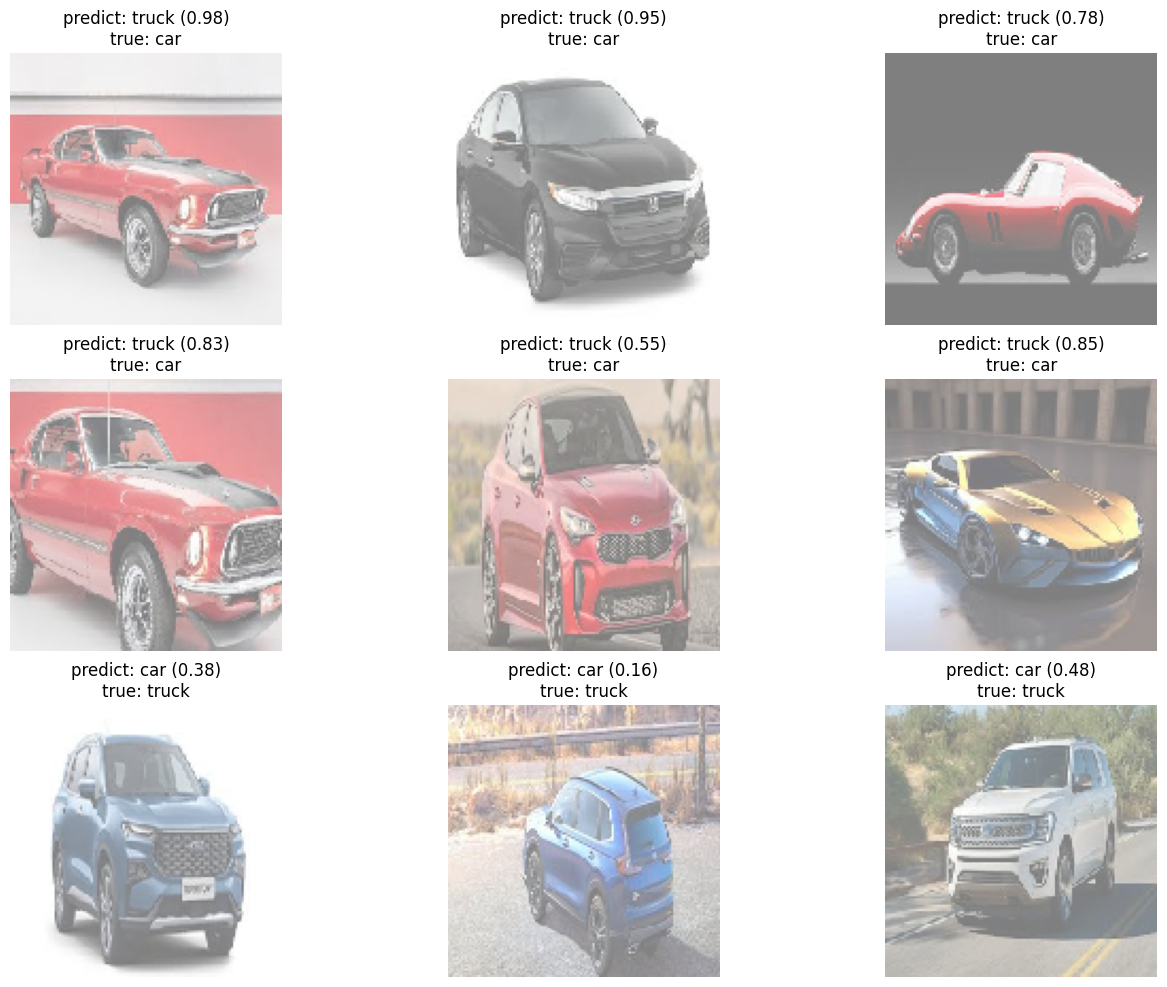

In [14]:
#Function to denormalize the images for visualization
def denormalize_image(image):
    return ((image + 1) * 127.5).astype(int)

error_images = np.array(error_images)
error_label = np.array(error_label)
error_pred = np.array(error_pred)
error_prob = np.array(error_prob)

max_images = len(error_images)
num_images = min(len(error_images), max_images)
w_size = 3
h_size = math.ceil(num_images / w_size)

#Ploting the images with wrong labels
plt.figure(figsize=(16, h_size * 4))

for ind in range(num_images):
    plt.subplot(h_size, w_size, ind + 1)
    image = error_images[ind]
    plt.imshow(denormalize_image(image))

    pred_label = labels[int(error_pred[ind])]
    pred_prob = error_prob[ind]
    true_label = labels[int(error_label[ind])]

    plt.title(f"predict: {pred_label} ({pred_prob:.2f})\ntrue: {true_label}", fontsize=12)
    plt.axis("off")

plt.show()

In [26]:
#There where two images in the test set of the movie cars
#Procedure to make sure that the prediction of these two images are correct
#List for the Cars data
cars_images = []
cars_labels = []
cars_pred = []
cars_prob = []

#Index of the images
lightning_mcqueen_index = 27
mate_index = 59

for _X_test, _y_test in ds_test:
    preds = model.predict(_X_test)

    for i in range(len(_X_test)):
        true_label = _y_test[i]
        pred_prob = preds[i][0]  # Probability of the positive class
        pred_label = 1 if pred_prob >= 0.5 else 0  # Making the prob to a binary label (0 or 1)

        # Getting only the data for the indexes
        if (i==lightning_mcqueen_index) or (i==mate_index):
            cars_images.append(_X_test[i].numpy())
            cars_labels.append(true_label.numpy())
            cars_pred.append(pred_label)
            cars_prob.append(pred_prob)

2/2 [==============================] - 0s 9ms/step


<ipython-input-27-7b0481dc062c>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = labels[int(cars_labels[ind])]


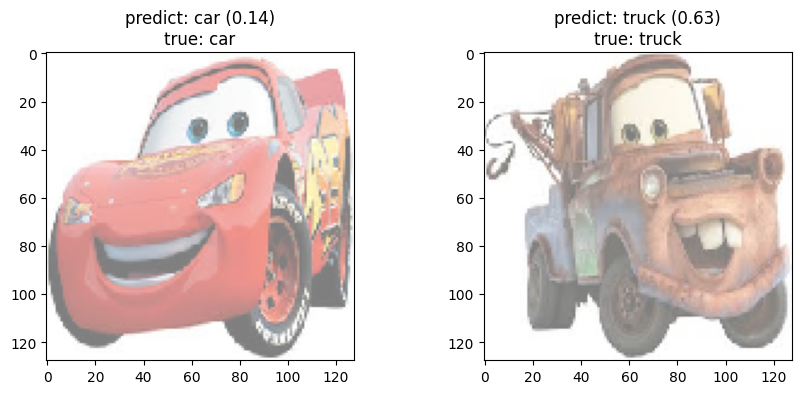

In [27]:
cars_images = np.array(cars_images)
cars_labels = np.array(cars_labels)
cars_pred = np.array(cars_pred)
cars_prob = np.array(cars_prob)

max_images_cars = len(cars_images)
num_images_cars = min(len(cars_images), max_images_cars)
w_size = 3
h_size = math.ceil(num_images_cars / w_size)

plt.figure(figsize=(16, h_size * 4))

# Ploting the images
for ind in range(num_images_cars):
    plt.subplot(h_size, w_size, ind + 1)
    image = cars_images[ind]
    plt.imshow(denormalize_image(image))

    pred_label = labels[int(cars_pred[ind])]
    pred_prob = cars_prob[ind]
    true_label = labels[int(cars_labels[ind])]

    plt.title(f"predict: {pred_label} ({pred_prob:.2f})\ntrue: {true_label}", fontsize=12)

plt.show()